### Daytum Course: Data Analytics, Geostatistics and Machine Learning Deep Dive

### Multidimensional Scaling Demonstration and Exercise

#### Goal

Detect patterns through projection of unconventional well production to a lower dimensional representation.

#### Description

Here's a demonstration of multidimensional scaling for subsurface modeling in Python.  

#### Multidimensional Scaling

A powerful ordination method in inferential statistics / information visualization for exploring / visualizing the similarity (conversely the difference) between individual samples from a high dimensional dataset.  

* beyond 2 or 3 features it is difficult to visualize the relationship between samples

* for 2 features we can easily visualize the relationships between samples with a scatter plot

* for 3 features we can either visualize in 3D or include color or matrix scatter plots

Multidimensional scaling projects the $m$ dimensional data to $p$ dimensions such that $p << m$.

* ideally we are able to project to $p=2$ to easily explore the relationships between the samples

While principal component analysis (PCA) operates with the covariance matrix, multidimensional scaling operates with the distance / dissimilarity matrix.

* you don't need to know the actual feature values, just the distance or dissimilarity between the samples

* as with any distance in feature space, we consider feature standardization and weighting

* we may also work with a variety of dissimilarity measures

#### Classical Multidimensional Scaling

Based on Euclidian distance between samples.

The Steps:

1. calculate the square distance matrix, $D^{(2)} = \left[ \delta_{i,j}^2 \right]$.

2. apply double centering $B = - \frac{1}{2} J D^{(2)} J$

3. solve for the Eigen Values, $\lambda_1,\ldots,\lambda_p$

4. solve for the projected coordinates, $x^{'}_1, \dots ,x^{'}_p$

\begin{equation}
X^{'} = E_m \land^{\frac{1}{2}}_m
\end{equation}

where $E_m$ is the matrix of Eigen vectors and $\land_m$ is the diagonal matrix of Eigen values. 

General comments about classical multidimensional scaling:

* nonlinear dimensionality reduction

* no distribution assumption

* the transform may not be unique, and may be arbitrarily be translated, rotated and transformed (these do not change the pairwise distances $||x_i - x_j||$.

#### Metric Multidimensional Scaling

A generalization of classical multidimensional scaling with a variety of metrics and a loss function optimization.

* formulated as an optimization problem to minimize the squate difference between the original and projected pairwise distances

\begin{equation}
min_{x_1,\ldots,x_m} \sum_{i<j} \left( ||x_i - x_j|| - \delta_{i,j} \right)^2
\end{equation}

where $||x_i - x_j||$ are the pairwise distances in the projected space ($p$ dimensional) and $\delta_{i,j}$ are the pairwise distances in the original feature space.

General comments about metric multidimensional scaling:

* dissimilarity measure must be meaningful

* dimensionality reduction is performed such that the error in the sample pairwise distance is minimized

* there is a variant known as Nonmetric Multidimensional Scaling for ordinal features (categorical with ordering).

#### Checking Multidimensional Scaling Results

The multidimensional scaling approach minimizes the square difference of the pairwise distances between all of the data samples and eachother between the projected, lower dimensional, and original feature space.

* **stress** is defined as:

\begin{equation}
Stress_P(x_1,\ldots,x_n) = \left( \sum_{i \ne j = 1,\ldots,n} \left( ||x_i - x_j|| - \delta_{i,j} \right)^2 \right)^{\frac{1}{2}}
\end{equation}

* it is also useful to visualize the scatterplot of projected vs. original pairwise distances

#### Comparison with Principal Component Analysis

Principal component analysis takes the covariance matrix ($m \times m$) between all the features and finds the orthogonal rotation such that the **variance is maximized** over the ordered principle components.  

Multidimensional scaling takes the matrix of the pairwise distances ($n \times n$) between all the samples in feature space and finds the nonlinear projects such that the **error in the pairwise distances is minimized**.

#### Random Projection

An alternative multidimensional scaling that relies on an random ($p \times n$) projection matrix, with columns with unit length.

* first row is a random unit vector 

* second row is orthogonal to the first row

* continue 

This random approach works practically because of the The Johnson-Lindenstrauss lemma:

*In mathematics, the Johnson-Lindenstrauss lemma is a result concerning low-distortion embeddings of points from high-dimensional into low-dimensional Euclidean space. The lemma states that a small set of points in a high-dimensional space can be embedded into a space of much lower dimension in such a way that distances between the points are nearly preserved. The map used for the embedding is at least Lipschitz, and can even be taken to be an orthogonal projection.* - Wikipedia article.

We will need some standard packages.

In [1]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import math                               # trigonometry etc.
import scipy.signal as signal             # kernel for moving window calculation
import random                             # for randon numbers
import seaborn as sns                     # for matrix scatter plots
from scipy import linalg                  # for linear regression


from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.random_projection import SparseRandomProjection
from sklearn.metrics.pairwise import euclidean_distances

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/daytum/intake-data/refs/heads/master/daytum_cat/data/unconv_MV_v4.csv')
df['TOC'] = np.where(df['TOC']<0.0, 0.0, df['TOC']) # set TOC < 0.0 as 0.0, otherwise leave the same

Visualizing the DataFrame would be useful and we already learned about these methods in this demo (https://git.io/fNgRW). 

We can preview the DataFrame by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). With the head command, add parameter 'n=13' to see the first 13 rows of the dataset.  

In [3]:
df.head(n=13)                             # we could also use this command for a table preview

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,1695.360819
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3007.096063
2,3,14.02,2.59,4.01,72.80,0.89,2.72,2531.938259
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5288.514854
4,5,17.52,4.57,3.18,10.94,1.51,1.90,2859.469624
5,6,14.53,4.81,2.69,53.60,0.94,1.67,4017.374438
6,7,13.49,3.60,2.93,63.71,0.80,1.85,2952.812773
7,8,11.58,3.03,3.25,53.00,0.69,1.93,2670.933846
8,9,12.52,2.72,2.43,65.77,0.95,1.98,2474.048178
9,10,13.25,3.94,3.71,66.20,1.14,2.65,2722.893266


This dataset has features from 200 unconventional wells including: 

0. well index
1. well average porosity (%) 
2. permeability (mD)
3. accoustic impedance (kg/m2s*10^6)
4. brittness ratio (%) 
5. total organic carbon (%) 
6. vitrinite reflectance (%)
8. normalized initial production 90 day average (MCFPD). 

Note, the dataset is synthetic, but has realistic ranges and general multivariate relationships.

Ranking features is really an effort to understand the features and their relationships with eachother.  We will start with basic data visualization and move to more complicated methods such are partial correlation and recursive feature elimination.

#### Summary Statistics

Let's check the summary statistics of our data.

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Well,200.0,100.500000,57.879185,1.000000,50.750000,100.500000,150.250000,200.000000
Por,200.0,14.991150,2.971176,6.550000,12.912500,15.070000,17.402500,23.550000
Perm,200.0,4.330750,1.731014,1.130000,3.122500,4.035000,5.287500,9.870000
AI,200.0,2.968850,0.566885,1.280000,2.547500,2.955000,3.345000,4.630000
Brittle,200.0,48.161950,14.129455,10.940000,37.755000,49.510000,58.262500,84.330000
TOC,200.0,0.991950,0.478264,0.000000,0.617500,1.030000,1.350000,2.180000
VR,200.0,1.964300,0.300827,0.930000,1.770000,1.960000,2.142500,2.870000
Prod,200.0,3864.407081,1553.277558,839.822063,2686.227611,3604.303506,4752.637555,8590.384044


Summary statistics are a critical first step in data checking. 

* this includes the number of valid (non-null) values for each feature (count removes all np.NaN from the totals for each variable).

* we can see the general behavoirs such as central tendency, mean, and dispersion, variance. 

* we can identify issue with negative values, extreme values, and values that are outside the range of plausible values for each property. 

* We can also establish the feature ranges for plotting.  We could calculate the feature range directly from the data with code like this:

```p
Pormin = np.min(df['Por'].values)          # extract ndarray of data table column
Pormax = np.max(df['Por'].values)          # and calculate min and max
```

but, this would not result in easy to understand color bars and axis scales, let's pick convenient round numbers. We will also declare feature labels for ease of plotting. 

In [5]:
pormin = 6.0; pormax = 24.0; porname = 'Porosity (%)'; portitle = 'Porosity' # user specified min and max values, and labels for plotting
permmin = 0.0; permmax = 10; permname = 'Permeability (mD)'; permtitle = 'Permeability'                
AImin = 1.0; AImax = 5.0; AIname = 'Acoustic Impedance (kg/m2s*10^6)'; AItitle = 'Acoustic Impedance'
brmin = 10.0; brmax = 85.0; brname = 'Brittleness Ratio (%)'; brtitle = 'Brittleness'
TOCmin = 0.0; TOCmax = 2.2; TOCname = 'Total Organic Carbon (%)'; TOCtitle = 'Total Organic Carbon' 
VRmin = 0.9; VRmax = 2.9; VRname = 'Vitrinite Reflectance (%)'; VRtitle = 'Vitrinite Reflectance'
prodmin = 500.0; prodmax = 9000.0; prodname = 'Normalized Initial Production (MCFPD)'; prodtitle = 'Normalized Initial Production'

The data looks to be in pretty good shape and for brevity we skip outlier detection. Let's look at the distributions with a martix scatter plot from the Seaborn package.

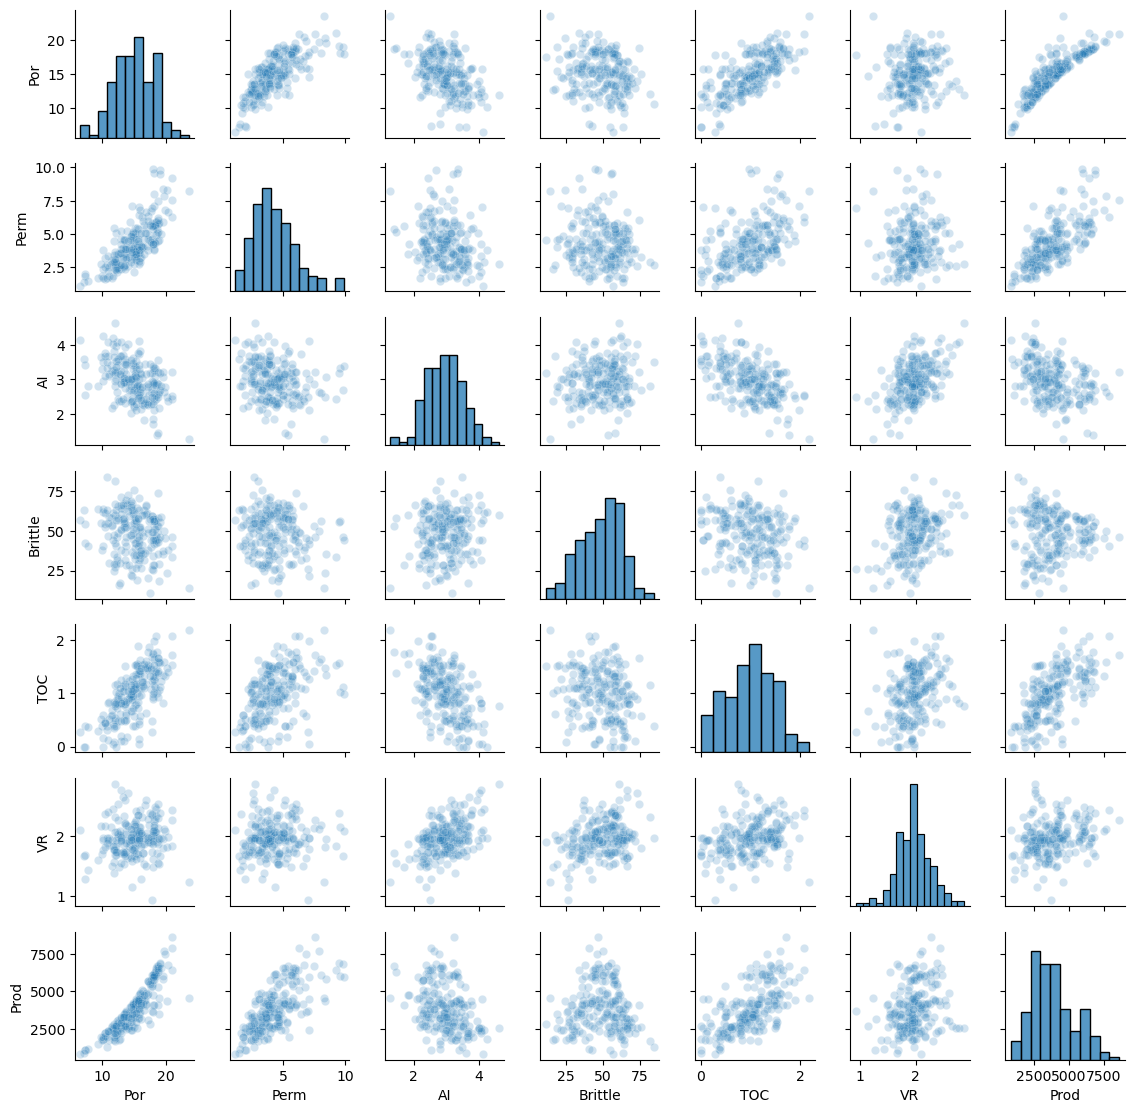

In [6]:
sns.pairplot(df,vars=['Por','Perm','AI','Brittle','TOC','VR','Prod'],markers='o',plot_kws={'alpha': 0.2})
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.6, top=0.6, wspace=0.3, hspace=0.2)
plt.show()

#### Data Preparation 

Let's make an ordinal feature from the continuous production:

1. low
2. medium
3. high
4. very high 

production rates.  This will help us visualize the results as we proceed, we can look at wells with different levels of production projected into a variety of lower dimensional spaces with multidimensional scaling.

In [7]:
bins = [0,2500,5000,7500,10000]                # assign the production bins (these are the fence posts)
labels = ['low', 'med', 'high', 'vhigh']       # assign the labels
category = pd.cut(df['Prod'],bins,labels=labels)     # make the 1D array with the labels for our data
df['tProd'] = category                                # add the new ordinal production feature to our DataFrames    
df.head()


,Well,Por,Perm,AI,Brittle,TOC,VR,Prod,tProd
0,1,12.08,2.92,2.80,81.40,1.16,2.31,1695.360819,low
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3007.096063,med
2,3,14.02,2.59,4.01,72.80,0.89,2.72,2531.938259,med
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5288.514854,high
4,5,17.52,4.57,3.18,10.94,1.51,1.90,2859.469624,med


Let's take a look at the matrix scatter plot of our 3 features and the production levels.

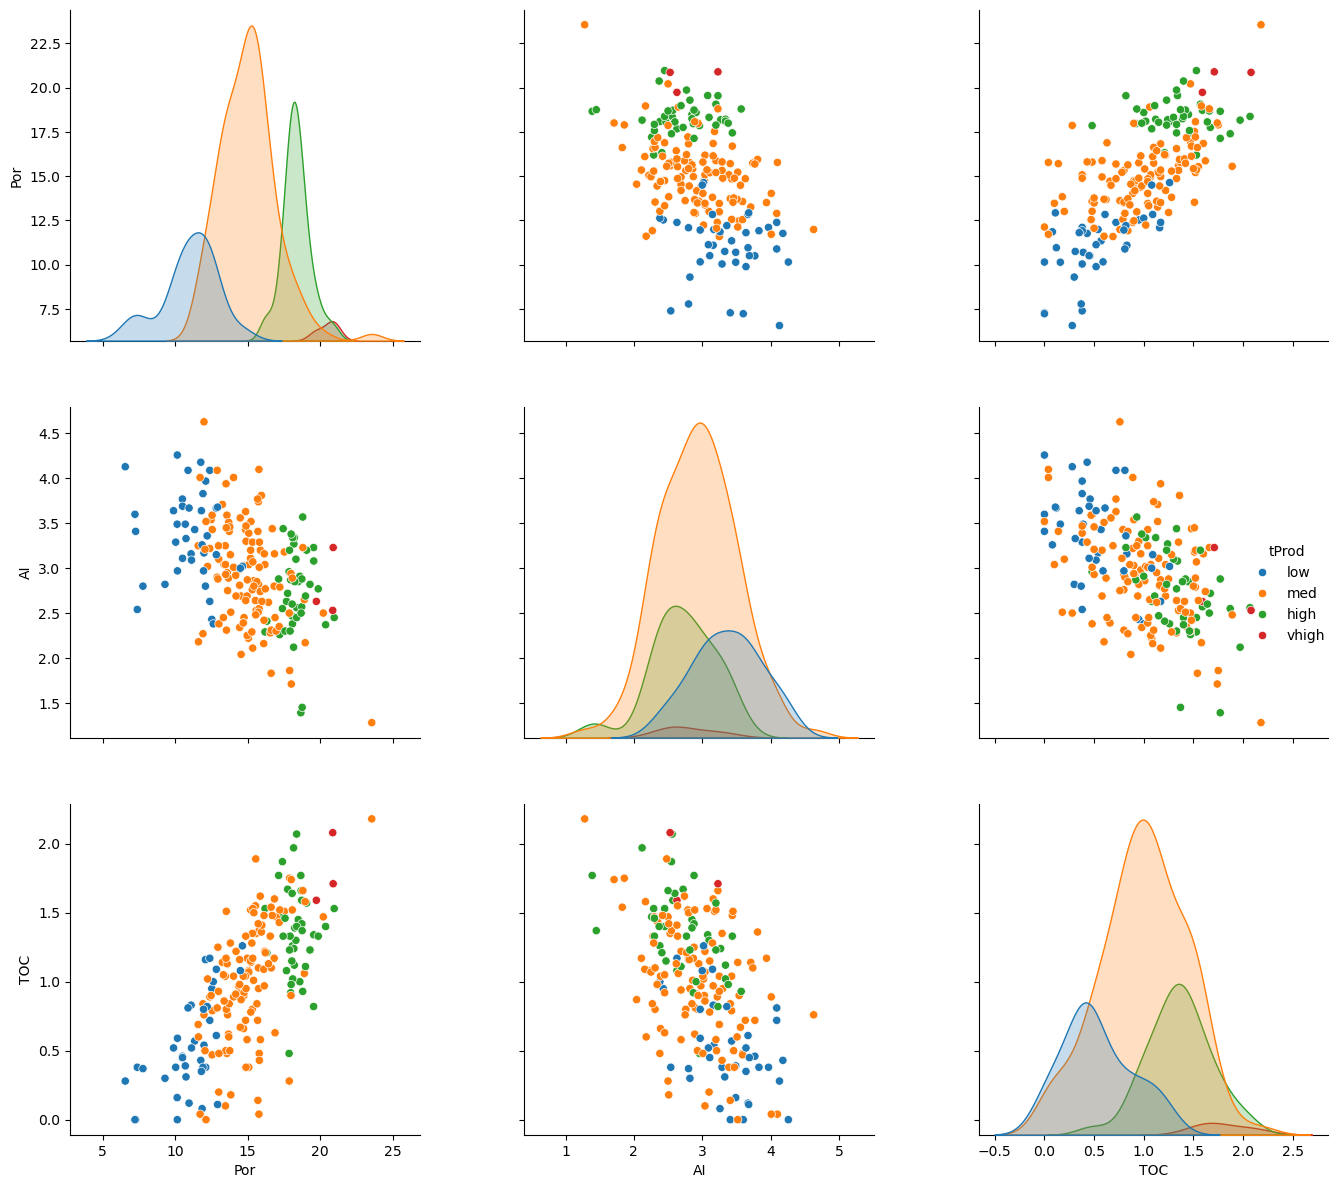

In [8]:
sns.pairplot(df[['Por','AI','TOC','tProd']],markers='o',hue = 'tProd')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.3, hspace=0.2)
plt.show()

#### Multidimensional Scaling

The multidimensional scaling method follows the sample pattern as other scikit-learn methods, we instantiate, fit and then apply or transform.

Let's run multidimensional scaling on our subset of features ($m = 3$) and project to only 2 features ($p = 2$).

In [9]:
from sklearn.manifold import MDS
n_components = 2
embedding = MDS(n_components=2)
MDS_transformed = embedding.fit_transform(df[['Por','AI','TOC']])
MDS_transformed.shape

/home/john/miniconda3/envs/daytum/lib/python3.14/site-packages/sklearn/manifold/_mds.py:744: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9. To suppress this warning, provide some value of `n_init`.
  warnings.warn(
/home/john/miniconda3/envs/daytum/lib/python3.14/site-packages/sklearn/manifold/_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(


(200, 2)

The output is 2 multidimensional scaling components.  We have projected our 3 features to 2 features to minimize the error in pairwise distance between the samples.  Let's add the 2 components to our DataFrame.

In [10]:
df['MDS1'] = MDS_transformed[:,0]
df['MDS2'] = MDS_transformed[:,1]
df.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod,tProd,MDS1,MDS2
0,1,12.08,2.92,2.80,81.40,1.16,2.31,1695.360819,low,-2.901628,-0.471404
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3007.096063,med,-2.633325,0.031405
2,3,14.02,2.59,4.01,72.80,0.89,2.72,2531.938259,med,-1.006004,0.956743
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5288.514854,high,2.695973,-0.109787
4,5,17.52,4.57,3.18,10.94,1.51,1.90,2859.469624,med,2.516331,-0.672918


Let's take a look at the samples projected into the new 2 dimensional feature space.  

* note the rotation, translation is arbitrary in this space, only the sample pairwise distances are relevant. 

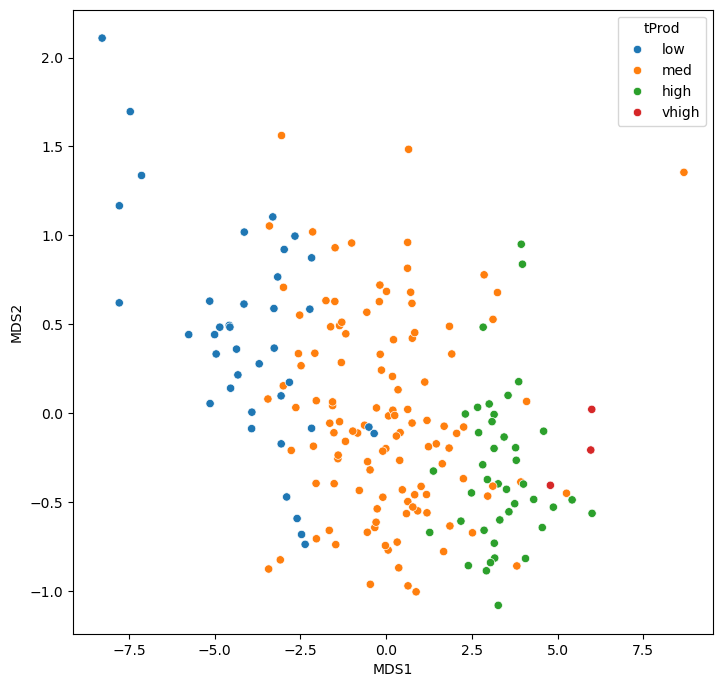

In [11]:
pairplot = sns.scatterplot(x = df['MDS1'],y = df['MDS2'],hue = df['tProd'],markers='o')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1.3, wspace=0.3, hspace=0.2)
plt.show()

Some comments:

* the general relationship between samples is preserved.

* the general production transition from low to very high production is preserved.

Let's check our model:

* we will calculate the original and projected pairwise distances between all the samples

* we will cross plot the original vs the projects pairwise distances

* we will plot the distribution of the ratio between projects / original pariwise distances


Distance Ratio, mean: 0.97, standard deviation 0.12.


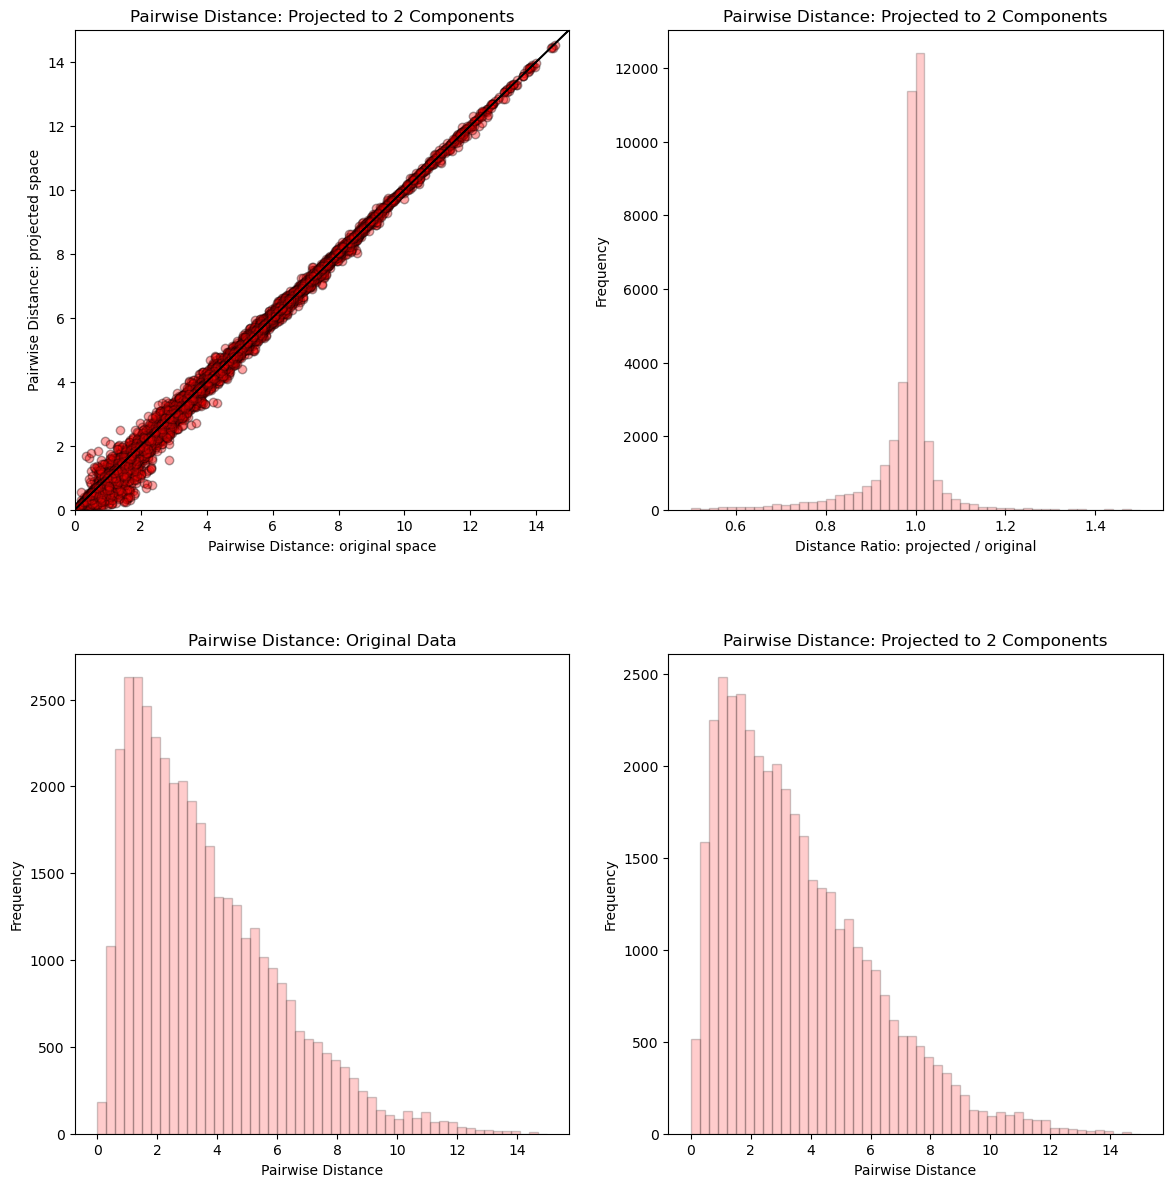

In [12]:
dists = euclidean_distances(df[['Por','AI','TOC']], squared=False).ravel()
nonzero = dists != 0   # select only non-identical samples pairs
dists = dists[nonzero]
projected_dists = euclidean_distances(MDS_transformed, squared=False).ravel()[nonzero]

plt.subplot(221)
plt.scatter(dists,projected_dists,c='red',alpha=0.2,edgecolor = 'black')
plt.arrow(0,0,200,200,width=0.02,color='black',head_length=0.0,head_width=0.0)
plt.xlim(0,15); plt.ylim(0,15)
plt.xlabel("Pairwise Distance: original space")
plt.ylabel("Pairwise Distance: projected space")
plt.title("Pairwise Distance: Projected to %d Components" % n_components)

rates = projected_dists / dists
print("Distance Ratio, mean: %0.2f, standard deviation %0.2f." % (np.mean(rates), np.std(rates)))

plt.subplot(222)
plt.hist(rates, bins=50, range=(0.5, 1.5),color = 'red', alpha = 0.2, edgecolor='k')
plt.xlabel("Distance Ratio: projected / original")
plt.ylabel("Frequency")
plt.title("Pairwise Distance: Projected to %d Components" % n_components)

plt.subplot(223)
plt.hist(dists, bins=50, range=(0., 15.),color = 'red', alpha = 0.2, edgecolor='k')
plt.xlabel("Pairwise Distance")
plt.ylabel("Frequency")
plt.title("Pairwise Distance: Original Data")

plt.subplot(224)
plt.hist(projected_dists, bins=50, range=(0., 15.),color = 'red', alpha = 0.2, edgecolor='k')
plt.xlabel("Pairwise Distance")
plt.ylabel("Frequency")
plt.title("Pairwise Distance: Projected to %d Components" % n_components)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.7, top=2.3, wspace=0.2, hspace=0.3)
plt.show()

We projected to a 2 dimensional feature space and did a pretty good job preserving the pairwise distances between the samples.

#### Observing Specific Samples

Let's reduce the number of wells and actually post the well numbers and observe their spacings in the original and projected features spaces.

In [13]:
df_subset = df.iloc[:30,:]

Let's look at out dataset, we will visualize the 3 possible scatter plots between the three features with the sample points labeled by well number (1 through 30).

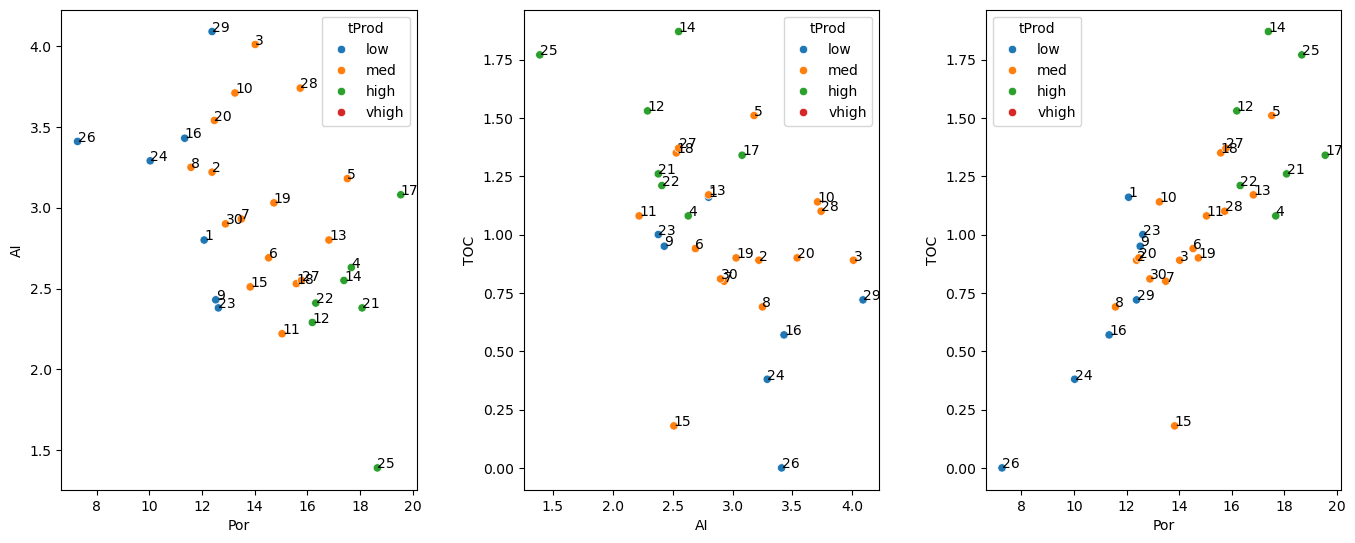

In [14]:
plt.subplot(131)
pairplot = sns.scatterplot(x = df_subset['Por'],y = df_subset['AI'],hue = df_subset['tProd'],markers='o')
for i, txt in enumerate(df_subset['Well']):
    pairplot.annotate(txt, (df_subset['Por'][i], df_subset['AI'][i]))
    
plt.subplot(132)
pairplot = sns.scatterplot(x = df_subset['AI'],y = df_subset['TOC'],hue = df_subset['tProd'],markers='o')
for i, txt in enumerate(df_subset['Well']):
    pairplot.annotate(txt, (df_subset['AI'][i], df_subset['TOC'][i]))
    
plt.subplot(133)
pairplot = sns.scatterplot(x = df_subset['Por'],y = df_subset['TOC'],hue = df_subset['tProd'],markers='o')
for i, txt in enumerate(df_subset['Well']):
    pairplot.annotate(txt, (df_subset['Por'][i], df_subset['TOC'][i]))
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1., wspace=0.3, hspace=0.2)
plt.show()

We can now see our 30 wells with their indices plots on each of the 3 possible bivariate plots.  Let's perform multidimensional scaling down to 2 components.

In [15]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2)
MDS_transformed = embedding.fit_transform(df_subset[['Por','AI','TOC']])
MDS_transformed.shape

/home/john/miniconda3/envs/daytum/lib/python3.14/site-packages/sklearn/manifold/_mds.py:744: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9. To suppress this warning, provide some value of `n_init`.
  warnings.warn(
/home/john/miniconda3/envs/daytum/lib/python3.14/site-packages/sklearn/manifold/_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(


(30, 2)

Now let's visualize the wells in the projected feature space.

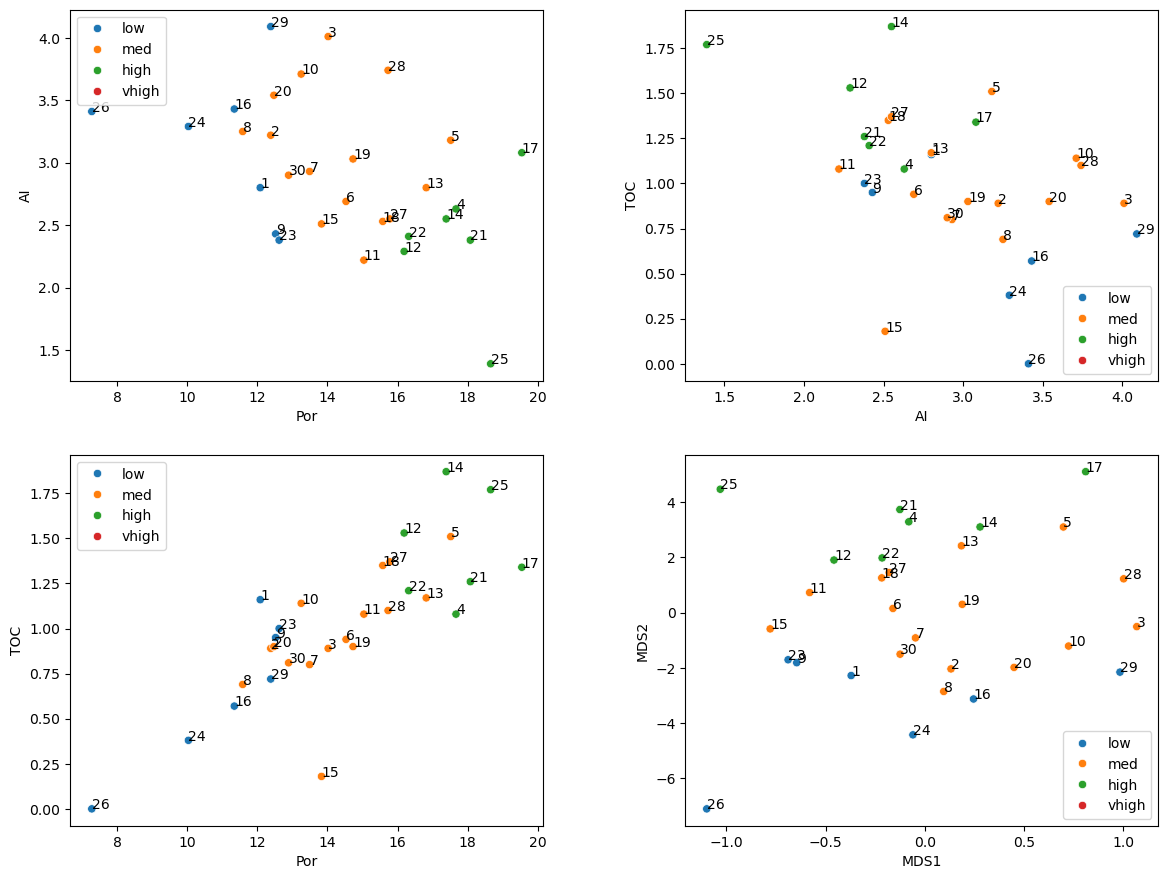

In [16]:
plt.subplot(221)
pairplot = sns.scatterplot(x = df_subset['Por'],y = df_subset['AI'],hue = df_subset['tProd'],markers='o')
for i, txt in enumerate(df_subset['Well']):
    pairplot.annotate(txt, (df_subset['Por'][i], df_subset['AI'][i]))
pairplot.legend(loc='upper left')  

plt.subplot(222)
pairplot = sns.scatterplot(x = df_subset['AI'],y = df_subset['TOC'],hue = df_subset['tProd'],markers='o')
for i, txt in enumerate(df_subset['Well']):
    pairplot.annotate(txt, (df_subset['AI'][i], df_subset['TOC'][i]))
pairplot.legend(loc='lower right')     
    
plt.subplot(223)
pairplot = sns.scatterplot(x = df_subset['Por'],y = df_subset['TOC'],hue = df_subset['tProd'],markers='o')
for i, txt in enumerate(df_subset['Well']):
    pairplot.annotate(txt, (df_subset['Por'][i], df_subset['TOC'][i]))
pairplot.legend(loc='upper left')     
    
plt.subplot(224)
pairplot = sns.scatterplot(x = MDS_transformed[:,0],y = MDS_transformed[:,1],hue = df_subset['tProd'],markers='o')
for i, txt in enumerate(df_subset['Well']):
    pairplot.annotate(txt, (MDS_transformed[i,0], MDS_transformed[i,1]))
pairplot.set_xlabel('MDS1'); pairplot.set_ylabel('MDS2')  
pairplot.legend(loc='lower right') 

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.7, top=1.7, wspace=0.3, hspace=0.2)
plt.show()

Some observations:

* the transformation is not a rotation (like PCA)

* the intersample distance is approximately preserved 

\begin{equation}
\delta_{i,j} = \left( (\delta Por_{i,j}^{2}) + (\delta AI_{i,j}^{2}) + (\delta TOC_{i,j}^{2}) \right)^{\frac{1}{2}}
\end{equation}

#### Applications

The main benefit with multiple dimensional scaling is the ability to inspect high dimensional feature spaces for relationships between samples.

* we may observe that specific wells cluster together
* we may observe systematic transitions

#### Random Projection

Let's demonstrate the use of random projection.

* given the low dimensionalilty you will see quite poor performance for some randon seeds

Distance Ratio, mean: 0.86, standard deviation 0.17.


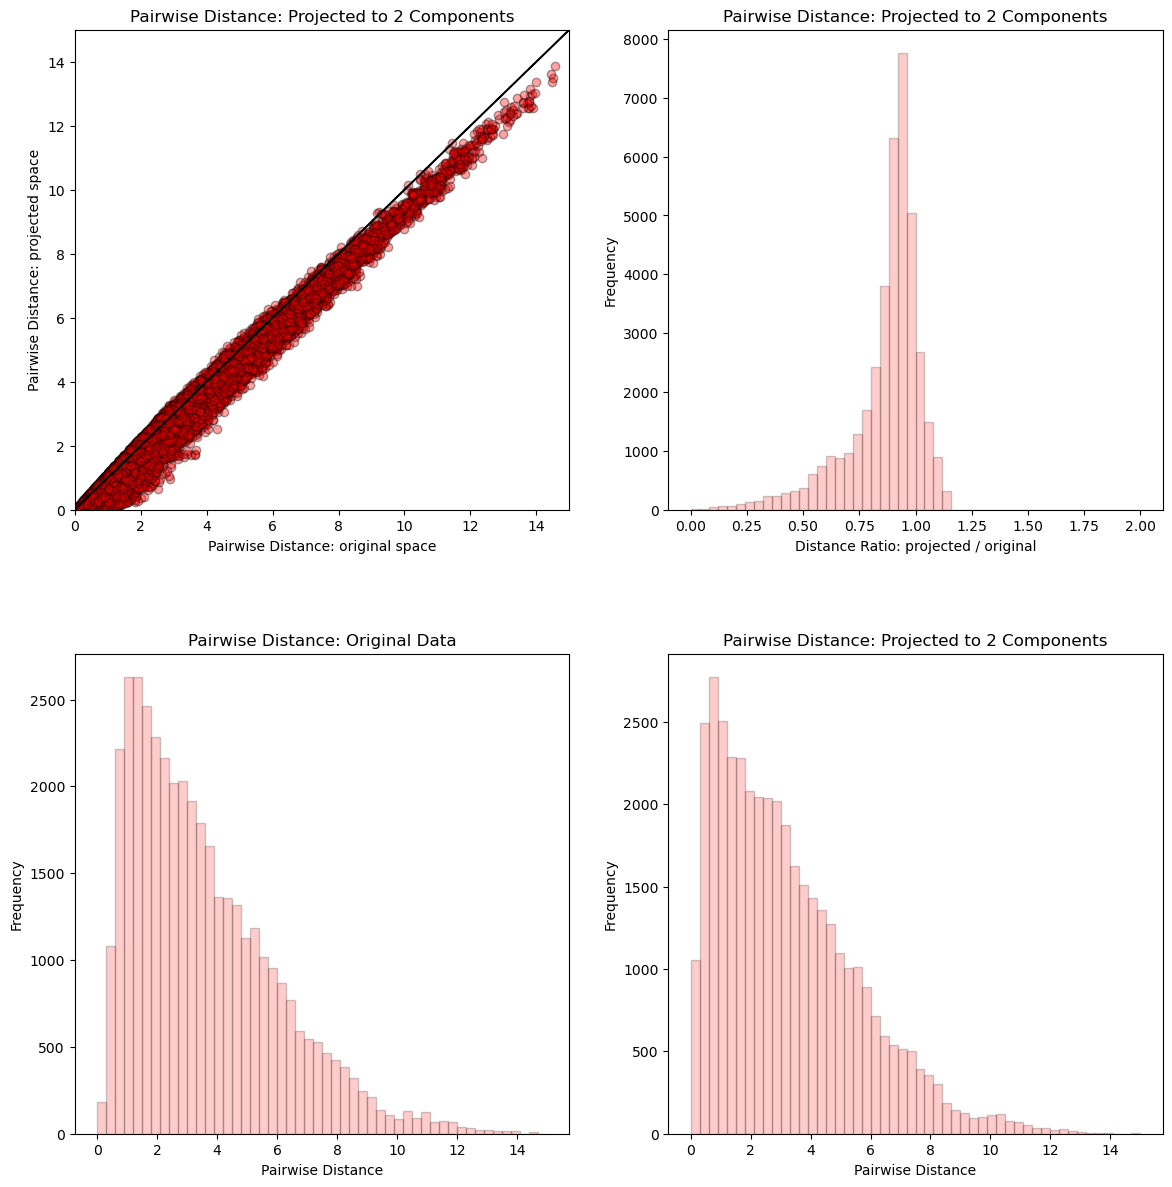

In [17]:
from sklearn.random_projection import GaussianRandomProjection
n_components = 2; seed = 73058
rp = GaussianRandomProjection(n_components=n_components,random_state = seed)

dists = euclidean_distances(df[['Por','AI','TOC']], squared=False).ravel()
nonzero = dists != 0   # select only non-identical samples pairs
dists = dists[nonzero]

projected_data = rp.fit_transform(df[['Por','AI','TOC']])
projected_dists = euclidean_distances(projected_data, squared=False).ravel()[nonzero]

plt.subplot(221)
plt.scatter(dists,projected_dists,c='red',alpha=0.2,edgecolor = 'black')
plt.arrow(0,0,200,200,width=0.02,color='black',head_length=0.0,head_width=0.0)
plt.xlim(0,15); plt.ylim(0,15)
plt.xlabel("Pairwise Distance: original space")
plt.ylabel("Pairwise Distance: projected space")
plt.title("Pairwise Distance: Projected to %d Components" % n_components)

rates = projected_dists / dists
print("Distance Ratio, mean: %0.2f, standard deviation %0.2f." % (np.mean(rates), np.std(rates)))

plt.subplot(222)
plt.hist(rates, bins=50, range=(0., 2.),color = 'red', alpha = 0.2, edgecolor='k')
plt.xlabel("Distance Ratio: projected / original")
plt.ylabel("Frequency")
plt.title("Pairwise Distance: Projected to %d Components" % n_components)

plt.subplot(223)
plt.hist(dists, bins=50, range=(0., 15.),color = 'red', alpha = 0.2, edgecolor='k')
plt.xlabel("Pairwise Distance")
plt.ylabel("Frequency")
plt.title("Pairwise Distance: Original Data")

plt.subplot(224)
plt.hist(projected_dists, bins=50, range=(0., 15.),color = 'red', alpha = 0.2, edgecolor='k')
plt.xlabel("Pairwise Distance")
plt.ylabel("Frequency")
plt.title("Pairwise Distance: Projected to %d Components" % n_components)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.7, top=2.3, wspace=0.2, hspace=0.3)
plt.show()

We should see improved performance (lower stress) for high dimensional problems (large $m$).

#### Comments

This was a basic demonstration of multidimensional scaling. A lot more could be done:  

* comparison to principal components analysis
* use of a dataset with larger number of features
* use of a dataset with natural clusters in multivariate space

<i>&copy; Copyright daytum 2021. All Rights Reserved</i>